<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/mmWave_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle
from tensorflow import keras
from keras.callbacks import History
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error
from WindowGenerator import WindowGenerator
import random as python_random
import argparse


np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

In [2]:
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

## HYPERPARAMETERS
# data_path = "data/fast_fading_dB_LOS_Head_Indoor_downsampled100hz_n50.txt"
data_path = "pathAB_SSF_dB_AP1_downsampled2Khz_win100.txt"
# TRAIN_STARTINDEX = 0
# TEST_ENDINDEX = 18113
MODEL = 'LSTM'
config_layer_1 = [25] # hidden units layer 1
# config_layer_2 = [1, 5, 10, 25, 50, 100, 200, 500] # hidden units layer 2
config_layer_2 = [] # declare this variable as an empty list for one-layer model
INPUT_WIDTH = 50
OUT_STEPS = 33
SHIFT = OUT_STEPS
# SHIFT = 10
MAX_EPOCHS = 50

## DON'T CHANGE
BATCHSIZE = 32
DROPOUT = 0.3

# Chosen min-max normalisation for the paper
NORM = 2

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv(data_path, header=None, delimiter=r"\s+")
df = df.rename(columns={0: "fast-fading (dB)"})
# df.plot(figsize=(10,8));

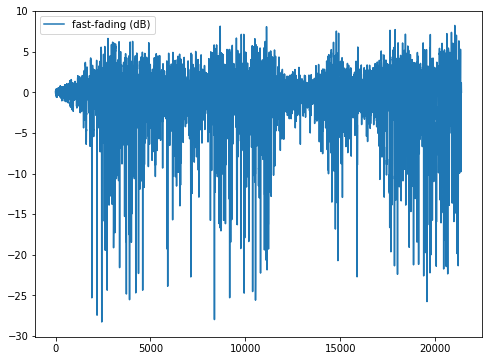

In [4]:
df.plot()

In [14]:
ts = df.copy()
ts.index = pd.date_range(start = '1-1-2020', periods = len(ts), freq = 'ms') 
ts.head(2)

,fast-fading (dB)
2020-01-01 00:00:00.000,0.000000
2020-01-01 00:00:00.001,-0.020739


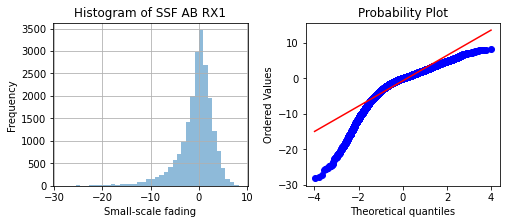

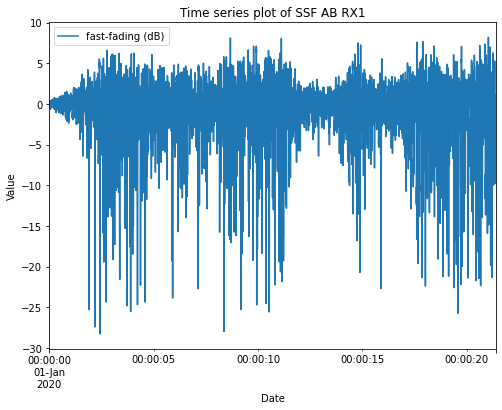

In [18]:
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')
import numpy.random as nr
nr.seed(2021)

def dist_ts(ts, lab = '', bins = 40):
    import scipy.stats as ss
    # two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    # histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Small-scale fading')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    # plot the q-q plot on the other axes
    ss.probplot(ts.squeeze(), plot = ax2)
    
dist_ts(ts, 'SSF AB RX1')
plot_ts(ts, 'SSF AB RX1')

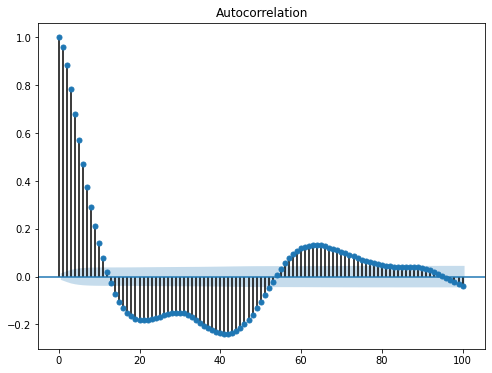

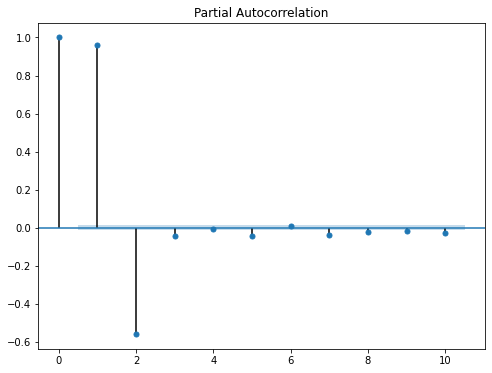

In [118]:
import statsmodels.graphics.tsaplots as splt
splt.plot_acf(ts, lags = 100)
splt.plot_pacf(ts, lags = 10)
plt.show()

In [103]:
np.abs(sts.seasonal_decompose(ts.values, model = 'additive', freq=2).resid)

array([       nan, 0.0461385 , 0.12803625, ..., 0.02904325, 0.009578  ,
              nan])

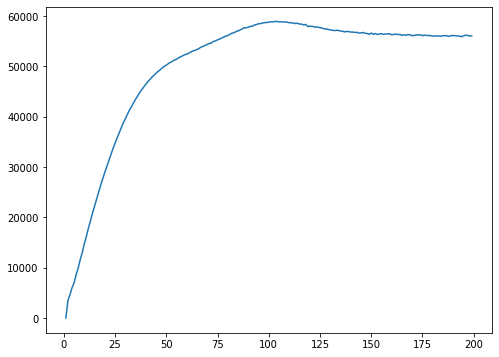

In [114]:
import statsmodels.tsa.seasonal as sts
import math


res_vs_lag = {}
for p in range(1, 200):
    res = sts.seasonal_decompose(ts.values, freq=p, model='additive')
    res = res.resid
    res = res[~np.isnan(res)]

    res_vs_lag[p] = np.sum(np.abs(res))

pd.Series(res_vs_lag).plot()

                     resid  trend  seasonal
2020-01-01 00:00:00    NaN    NaN  0.068448
2020-01-01 00:00:01    NaN    NaN -0.022386
2020-01-01 00:00:02    NaN    NaN -0.162550
2020-01-01 00:00:03    NaN    NaN -0.179101
2020-01-01 00:00:04    NaN    NaN -0.215383
2020-01-01 00:00:05    NaN    NaN -0.194410
2020-01-01 00:00:06    NaN    NaN -0.198634
2020-01-01 00:00:07    NaN    NaN -0.224375
2020-01-01 00:00:08    NaN    NaN -0.282186
2020-01-01 00:00:09    NaN    NaN -0.276724
2020-01-01 00:00:10    NaN    NaN -0.156255
2020-01-01 00:00:11    NaN    NaN -0.082759


,resid,trend,seasonal
2020-01-01 05:56:23,NaN,NaN,-0.046478
2020-01-01 05:56:24,NaN,NaN,-0.020218
2020-01-01 05:56:25,NaN,NaN,-0.024950
2020-01-01 05:56:26,NaN,NaN,0.054173
2020-01-01 05:56:27,NaN,NaN,0.139996
2020-01-01 05:56:28,NaN,NaN,0.172673
2020-01-01 05:56:29,NaN,NaN,0.201228
2020-01-01 05:56:30,NaN,NaN,0.228499
2020-01-01 05:56:31,NaN,NaN,0.275690
2020-01-01 05:56:32,NaN,NaN,0.296730


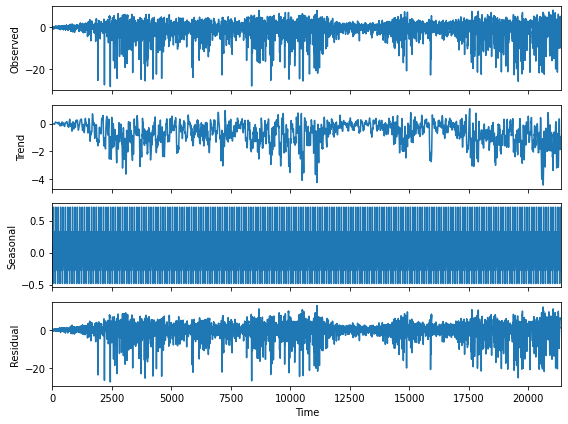

In [121]:
import statsmodels.tsa.seasonal as sts
def decomp_ts(ts, model = 'additive'):
    res = sts.seasonal_decompose(ts.values, model = model, freq=100) #, freq = freq)
    #resplot = res.plot()
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )
decomp = decomp_ts(ts)
print(decomp[:12])
decomp[-12:]

Text(0.5, 0, 'Date')

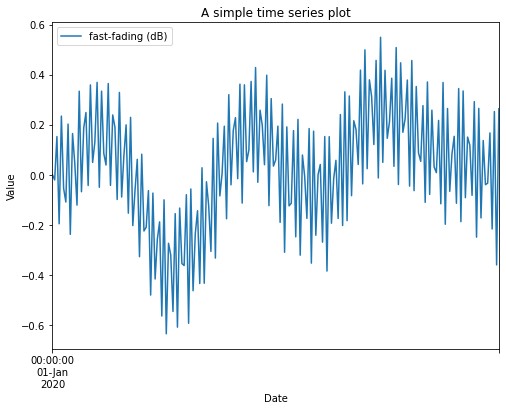

In [10]:
ts['1/1/2020 00:00:00.000':'1/1/2020 00:00:00.200'].plot()
plt.title('A simple time series plot')
plt.ylabel('Value')
plt.xlabel('Date')

In [ ]:
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')
import numpy.random as nr
nr.seed(2021)
white = pd.Series(nr.normal(size = 730),
                 index = pd.date_range(start = '1-1-2018', end = '12-31-2019', freq = 'D'))
plot_ts(white, 'white noise')